## Explainable AI (XAI) and Grad-CAM


In this session we will be covering

1. `gradcam` over `celebA` network

2. `gradcam` over `regression` task

3. Transfer learning and more techincal concepts in `pytorch`

### A closer look into implementation of `grad-cam`


In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pre-trained model

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)


In [ ]:
# Lets look into the model
# eval() Sets the module in evaluation mode.
# This has any effect only on certain modules.
# See documentations of particular modules for details of their behaviors in training/evaluation mode,
# if they are affected, e.g. Dropout, BatchNorm, etc.
# https://discuss.pytorch.org/t/where-to-use-model-eval/89200
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### PyTorch `hook`


In PyTorch, hooks are a powerful tool that allows you to modify or inspect the internal workings of a model at different points during the forward and backward passes. They can be useful for a variety of tasks, including:

#### Common Uses of Hooks in PyTorch:

1. **Debugging:**
    
    Hooks allow you to inspect the intermediate values (activations, inputs, outputs, gradients) of your network during training and inference. This can help diagnose issues like vanishing/exploding gradients, incorrect forward pass values, etc.

2. **Visualizing Activations:**

    You can register a forward hook to capture and visualize the activations of different layers in the network. This can be useful for understanding what features the network is learning.

3. **Gradient Inspection/Modification:**

    By using backward hooks, you can inspect and even modify the gradients as they propagate back through the network. This can be useful for custom gradient manipulation, such as implementing gradient clipping, gradient scaling, or custom backpropagation rules.

4. **Custom Regularization:**

    Hooks can be used to apply custom regularization techniques by modifying gradients or activations during training.

5. **Layer Freezing or Conditional Behavior:**

    During fine-tuning or transfer learning, you might want to freeze certain layers or apply conditional behavior. Hooks allow you to intervene during the forward or backward pass to control what happens at specific layers.

PyTorch provides two main types of hooks:

#### Forward Hook (`register_forward_hook`):

A forward hook is called after the forward pass has computed the output of a layer.

You can register a hook to any `nn.Module` (e.g., layers like `nn.Linear`, `nn.Conv2d`, etc.) to inspect or modify the input and output of the layer during the forward pass.



In [ ]:
def forward_hook(module, input, output):
    print (f"Input shape: {input[0].shape}")
    print (f"Output shape: {output.shape}")
    return output*0.

layer = model.fc  # Assume 'conv1' is a layer in the model
handle = layer.register_forward_hook(forward_hook)

input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor
output = model(input_tensor)

handle.remove()  # Remove the hook when you're done

print (output)

Input shape: torch.Size([1, 512])
Output shape: torch.Size([1, 1000])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., 0., 0., 0., 0., 0., -0., 0., 0., 0., -0., -0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0.,
         0., 0., 0., -0., 0., 0., -0., 0., -0., 0., 0., 0., 0., -0., -0., -0., 0., 0., -0., -0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., -0., 0., 0., -0., 0., 0., -0., -0., -0., 0., -0., -0., 0., -0., 0., -0.,
         0., -0., -0., 0., -0., -0., -0., -0., 0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., -0., 0., 0., 0., 0.,
         0., -0., 0., 0., 0., 0., 0., 0., 0., 0., -0., 0., 0., 0., 0., -0., -0., -0., 0., -0., -0., 0., -0., 0.,
         0., 0., -0., -0., 0., 0., 0., -0., -0., 0., -0., 0., -0., -0., -0., -0., -0., -0., 0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         

#### Backward Hook (`register_full_backward_hook`):

A backward hook is called during the backward pass after the gradients have been computed for a layer.
The full backward hook allows you to inspect or modify the gradients flowing backward through the network.
This hook is registered with the `register_full_backward_hook` function on a layer.

Usage:

It can be used to inspect the gradients, debug vanishing/exploding gradient problems, or modify the gradient flow.
It provides access to both the gradient of the loss with respect to the layer's input and the gradient with respect to the layer's output.

In [ ]:
def backward_hook(module, grad_input, grad_output):
    # Ensure grad_output is a tensor or a list of tensors
    print (f"grad_input shape is {grad_input[0].shape}")
    print (f"grad_output shape is {grad_output[0].shape}")
    return grad_input, grad_output

layer = model.fc  # Assume 'conv1' is a layer in the model
handle = layer.register_full_backward_hook(backward_hook)

input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor
output = model(input_tensor)
output[0, 0].backward()

handle.remove()  # Remove the hook when you're done

model.zero_grad()


grad_input shape is torch.Size([1, 512])
grad_output shape is torch.Size([1, 1000])


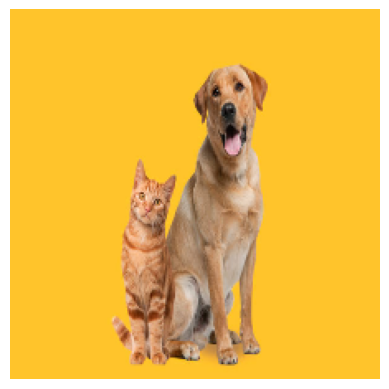

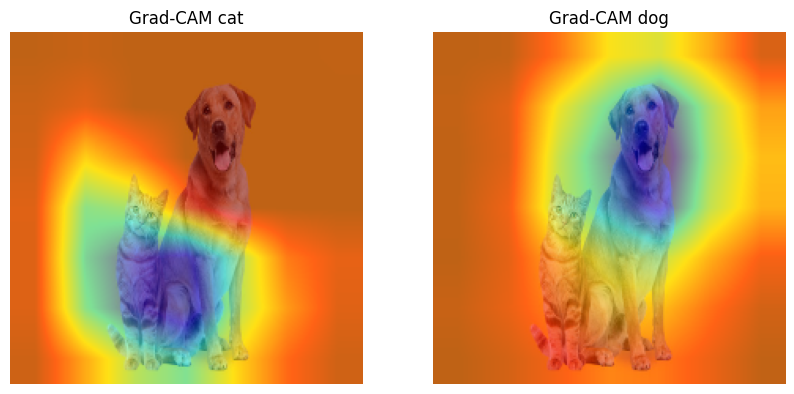

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
import requests
from io import BytesIO
from PIL import Image  # Make sure to import Image

# Define Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.forward_output = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.forward_output = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_layer = dict(self.model.named_modules())[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def forward(self, x):
        return self.model(x)

    def __call__(self, input_image, class_index=None):
        output = self.forward(input_image)

        if class_index is None:
            class_index = torch.argmax(output)

        self.model.zero_grad()
        class_score = output[:, class_index]
        class_score.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        forward_output = self.forward_output[0].cpu().data.numpy()

        # Global average pooling of gradients
        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(forward_output.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * forward_output[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

# Visualization function for heatmap
def visualize_cam(cam, image, alpha=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(image)
    cam_image = cam_image / np.max(cam_image)
    return np.uint8(255 * cam_image)
def fetch_and_transform(url, transform, image = "image.jpg"):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
        # Replace with your desired User-Agent string
    }
    response = requests.get(url, stream = True, headers = headers)
    response.raise_for_status()
    img = Image.open(BytesIO(response.content))
    img.save(image)
    imgtensor = transform(img).unsqueeze(0)
    img = cv2.resize(np.array(img), imgtensor.shape[2:])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return img, imgtensor
# Preprocessing for the input image (as used in ImageNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load pre-trained model (ResNet18)
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Load an image and preprocess
image_url_cat_dog = "https://media.istockphoto.com/id/1435010849/photo/labrador-retriever-dog-panting-and-ginger-cat-sitting-in-front-of-dark-yellow-background.jpg?s=612x612&w=0&k=20&c=obpeW_Aw7cIpQ8SfVHX9lMwLeLa00W1qmSFcOTVMEZ4="
image_url_boat_dog_human = "https://www.stockvault.net/data/2018/10/17/255259/preview16.jpg"
image_path = image_url_cat_dog  # Set the path to an image
original_image, input_tensor = fetch_and_transform(image_path, transform)

# Instantiate Grad-CAM
gradcam = GradCAM(model, target_layer='layer4')
# Perform Grad-CAM
cat = 281 # also, 282 283 284 285 286 287 are all cats
dog = 208 # for labrador retriever
labls = ["cat", "dog"]
cams = [gradcam(input_tensor, cat), gradcam(input_tensor, dog)]

fig, axes = plt.subplots(1, len(cams), figsize=(10, 5))

for i, cam in enumerate(cams):
    cam_image = visualize_cam(cam, original_image / 255)
    axes[i].imshow(cam_image)
    axes[i].set_title(f'Grad-CAM {labls[i]}')
    axes[i].axis('off')

plt.show()


### `gradcam` over `celebA` dataset


Let us trin the celebA dataset for age, from previous classes to regress over the age. We will be using VGG18 as our base model but modify the final fc layer to have a single output. This is




### Classification


In [ ]:
from IPython.display import Image as IPythonImage
%matplotlib inline
from IPython.core.display import display

In [ ]:
import torch
import torch.nn as nn
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2024-10-17 14:58:04--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.168, 52.219.192.24, 52.219.193.0, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  26.3MB/s    in 51s     

2024-10-17 14:58:55 (27.1 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "data_faces/"

img_align_celeba


In [ ]:
# Download all files in the Google Drive folder corresponding to the labels
!gdown --folder https://drive.google.com/drive/folders/1zIhmZAbpt9R3aM09wu3J1CixK0kluwMb -O data_faces/

Retrieving folder contents
Processing file 1W6PUogOswAGjWc3TS6acWewkGw7v72VO identity_CelebA.txt
Processing file 1bXoazwXbKK2dWxu_skhwv156Uq-gNZGe list_attr_celeba.txt
Processing file 1RE8Ojs0gs8BxPxd7ZtbmE7-_lZT1wNHK list_bbox_celeba.txt
Processing file 1xojfv4rXGdR7TB7-peFPrUFY-MLZQa3m list_eval_partition.txt
Processing file 18OZpHkC4Bpi2YMnewN9yriwLogAiVrsP list_landmarks_align_celeba.txt
Processing file 1Uh_UHnkJmmkPuYPmiKYcp2Ookum6JHEI list_landmarks_celeba.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1W6PUogOswAGjWc3TS6acWewkGw7v72VO
To: /content/data_faces/copied_celeba/identity_CelebA.txt
100% 3.42M/3.42M [00:00<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bXoazwXbKK2dWxu_skhwv156Uq-gNZGe
To: /content/data_faces/copied_celeba/list_attr_celeba.txt
100% 26.7M/26.7M [00:00<00:00, 68.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R

In [ ]:
# Move all files from copied_celeba to the data_faces root folder
!mv data_faces/copied_celeba/* data_faces/

In [ ]:
# Remove the empty copied_celeba folder
!rmdir data_faces/copied_celeba


In [ ]:
!ls data_faces/

identity_CelebA.txt   list_bbox_celeba.txt	       list_landmarks_celeba.txt
img_align_celeba      list_eval_partition.txt
list_attr_celeba.txt  list_landmarks_align_celeba.txt


In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CelebADataset(Dataset):
    def __init__(self, image_ids, attr_labels, img_folder, transform=None):
        self.image_ids = image_ids.tolist()  # Convert to list to avoid .iloc issues
        self.attr_labels = attr_labels.to_numpy()  # Convert to NumPy array for easier indexing
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Load image using list indexing
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_folder, img_id)
        image = Image.open(img_path)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Access label from the NumPy array (direct indexing)
        label = self.attr_labels[idx]  # Access the label using normal NumPy indexing

        return image, label


# Path to your dataset folder
image_path = "/content/data_faces"
img_folder = os.path.join(image_path, 'img_align_celeba')

# Paths to the required files
attr_file = os.path.join(image_path, 'list_attr_celeba.txt')
partition_file = os.path.join(image_path, 'list_eval_partition.txt')

# Step 1: Load the attributes and partition data
attributes = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)
partition = pd.read_csv(partition_file, delim_whitespace=True, header=None, names=['image_id', 'partition'])

attr = attributes.map(lambda x: 1 if x == 1 else 0) # The "Smiling" attribute is already labeled

# Step 3: Split the dataset into train, validation, and test sets based on partition file
train_data = partition[partition['partition'] == 0]  # Train set
valid_data = partition[partition['partition'] == 1]  # Validation set
test_data = partition[partition['partition'] == 2]   # Test set

# Extract the image ids and corresponding labels (Smiling or not)
train_labels = attr.loc[train_data['image_id']]
valid_labels = attr.loc[valid_data['image_id']]
test_labels = attr.loc[test_data['image_id']]

# Step 4: Create Transformations (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Step 5: Create Dataset Objects using the custom CelebADataset class
celeba_train_dataset = CelebADataset(train_data['image_id'], train_labels, img_folder, transform)
celeba_valid_dataset = CelebADataset(valid_data['image_id'], valid_labels, img_folder, transform)
celeba_test_dataset = CelebADataset(test_data['image_id'], test_labels, img_folder, transform)

# Print the dataset sizes
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

<ipython-input-39-22240dc06106>:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  attributes = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)
<ipython-input-39-22240dc06106>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  partition = pd.read_csv(partition_file, delim_whitespace=True, header=None, names=['image_id', 'partition'])


Train set: 162770
Validation set: 19867
Test set: 19962


In [ ]:
print (*attributes.columns[1:].to_list(), sep="\n")

Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [ ]:
# Lets make some loaders

batch_size = 1024

train_loader = torch.utils.data.DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(celeba_valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(celeba_test_dataset, batch_size=1, shuffle=False)

# Print out the shape of inputs and outputs from loaders

for inputs, labels in train_loader:
    print(f"Inputs shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Inputs shape: torch.Size([1024, 3, 64, 64])
Labels shape: torch.Size([1024, 40])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

# Load a pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers except the 4th layer
for name, param in model.named_parameters():
        param.requires_grad = False  # Freeze all layers except layer4

# Modify the fully connected layer to output 40 units (for 40 attributes)
model.fc = nn.Linear(model.fc.in_features, 40)

# Use BCEWithLogitsLoss for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Set up an optimizer to train only the parameters of layer4 and the fc layer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(preds, labels, threshold=0.5):
    # Apply sigmoid to the predictions to get probabilities
    preds = torch.sigmoid(preds)
    # Convert probabilities to binary (0 or 1) using the threshold
    predicted_labels = (preds >= threshold).float()
    correct = (predicted_labels == labels).float().sum()
    accuracy = correct / (labels.numel())
    return accuracy

In [ ]:

# Step 0: Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Move the model to the selected device (GPU or CPU)
model = model.to(device)

# Training and validation loop
epochs = 10
for epoch in range(epochs):
    model.train()

    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    valid_accuracy = 0.0

    # Training loop
    batch = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute training loss
        labels = labels.float()
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        accuracy = calculate_accuracy(outputs, labels)
        train_accuracy += accuracy.item()

        if (batch % 10 == 0):
            print (f"Done with {(batch+1)*batch_size} samples")
        batch += 1

    # Compute average training loss and accuracy
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    # Validation loop
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)
            labels = labels.float()
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            accuracy = calculate_accuracy(outputs, labels)
            valid_accuracy += accuracy.item()

    # Compute average validation loss and accuracy
    valid_loss /= len(valid_loader)
    valid_accuracy /= len(valid_loader)

    # Print the metrics for the current epoch
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

Using device: cuda


In [ ]:
# After training, compute test accuracy
model.eval()  # Set the model to evaluation mode for testing
test_loss = 0.0
test_accuracy = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model(images)
        labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss

        # Compute test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Compute test accuracy
        accuracy = calculate_accuracy(outputs, labels)
        test_accuracy += accuracy.item()

# Compute average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy /= len(test_loader)

# Print final test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2643, Test Accuracy: 0.8810


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.transforms import transforms

# Assuming you have your `test_dataset` and `model` already set up

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import random

# Assuming test_loader is your DataLoader for the test dataset
data_iter = iter(test_loader)

# Convert DataLoader to a list
data_list = list(test_loader)

# Select a random batch
random_batch = random.choice(data_list)

# Get the inputs (images) and labels from the random batch
image, labels = random_batch

image = image.to(device)

outputs shape :  torch.Size([40])


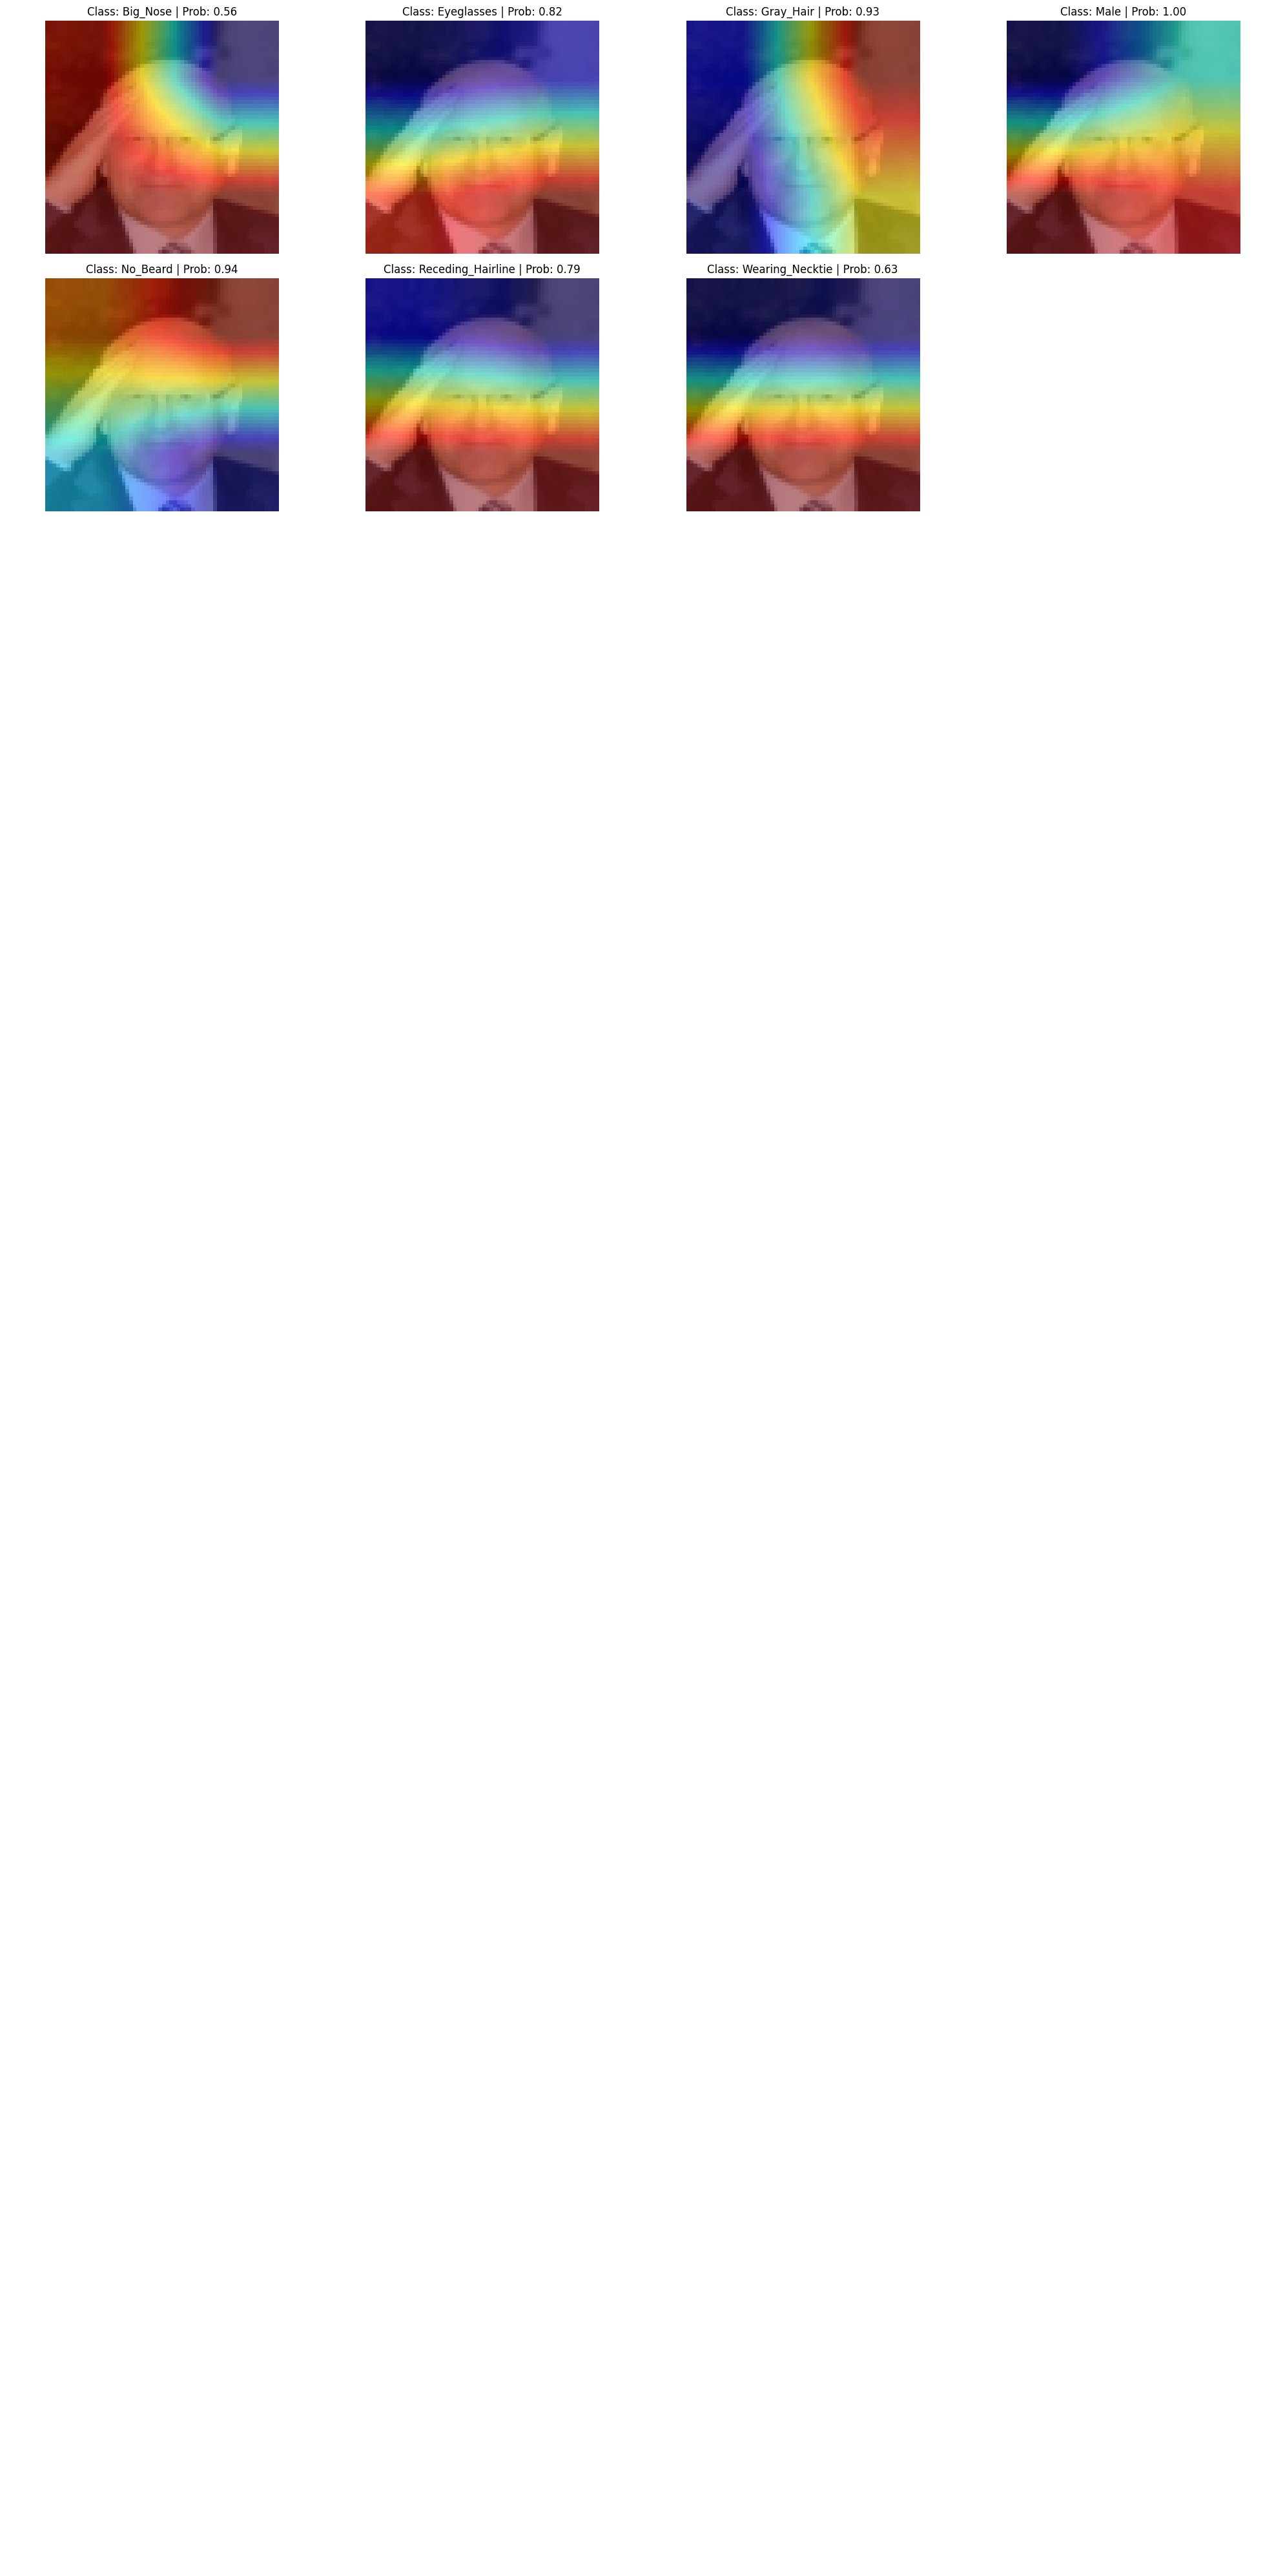

In [ ]:

label_names = {i : name for i, name in enumerate(attributes.columns)}
# Grad-CAM setup (assuming you've defined the GradCAM class)
grad_cam = GradCAM(model, target_layer='layer4')  # Target layer for ResNet18

# Forward pass through the model to get predictions
model.to(device)
model.eval()
outputs = model(image)
outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
outputs = outputs.squeeze()  # Remove extra dimensions


print ("outputs shape : ", outputs.shape)

# Select the classes with confidence >= 50%
threshold = 0.5
selected_classes = (outputs >= threshold).nonzero(as_tuple=True)[0]  # Get indices of confident predictions
selected_probs = outputs[selected_classes].detach().cpu().numpy()  # Get the probabilities of these predictions

# Visualize CAM for each selected class in a 10x4 grid
fig, axs = plt.subplots(10, 4, figsize=(20, 40))

# Prepare the image for CAM visualization
image_np = image[0].cpu().numpy().transpose(1, 2, 0)  # Convert from tensor to NumPy array
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize the image

for i, class_index in enumerate(selected_classes):
    if i >= 40:  # Limit to 40 images (10x4 grid)
        break

    # Generate CAM for the selected class
    cam = grad_cam(image, class_index=class_index.item())

    # Visualize the CAM
    cam_image = visualize_cam(cam, image_np)

    # Plot the image with the corresponding label and probability
    ax = axs[i // 4, i % 4]
    ax.imshow(cam_image)
    ax.set_title(f"Class: {label_names[class_index.item()]} | Prob: {selected_probs[i]:.2f}")
    ax.axis('off')

# Hide unused subplots if any
for j in range(i + 1, 40):
    axs[j // 4, j % 4].axis('off')

plt.tight_layout()
plt.show()


### Gradcam++

In [ ]:
import torch
import numpy as np
import cv2
import torch.nn.functional as F

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.model.eval()  # Ensure the model is in evaluation mode
        self.hook_layers()

    def hook_layers(self):
        """Attach hooks to the target layer to capture gradients and activations."""
        def forward_hook(module, input, output):
            self.activations = output  # Capture the forward activations

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]  # Capture the gradients

        target_layer = dict(self.model.named_modules())[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def forward(self, x):
        return self.model(x)

    def __call__(self, input_image, class_index=None):
        # Forward pass
        output = self.forward(input_image)

        if class_index is None:
            # Use the top predicted class if none is specified
            class_index = torch.argmax(output)

        self.model.zero_grad()  # Zero all gradients
        class_score = output[:, class_index]  # Select the class score
        class_score.backward(retain_graph=True)  # Compute gradients

        # Get gradients and activations for the target layer
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute alpha (importance weight for each pixel location)
        alpha_num = gradients ** 2
        alpha_denom = 2 * gradients ** 2 + np.sum(activations * gradients ** 3, axis=(1, 2), keepdims=True)
        alpha_denom = np.where(alpha_denom != 0, alpha_denom, 1e-8)  # Avoid division by zero
        alpha = alpha_num / alpha_denom

        # Compute weights
        weights = np.sum(alpha * np.maximum(gradients, 0), axis=(1, 2))

        # Compute the Grad-CAM++ map
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Resize CAM to match input size
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))

        # Normalize CAM to [0, 1]
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)

        return cam

# Visualization function for Grad-CAM++
def visualize_gradcamplusplus(cam, image, alpha=0.5):
    """
    Visualize the Grad-CAM++ heatmap overlayed on the original image.

    Args:
        cam: The Grad-CAM++ map.
        image: The original input image as a NumPy array.
        alpha: The blending factor for overlay.

    Returns:
        Blended image with CAM overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(image)
    cam_image = cam_image / np.max(cam_image)
    return np.uint8(255 * cam_image)


outputs shape :  torch.Size([40])


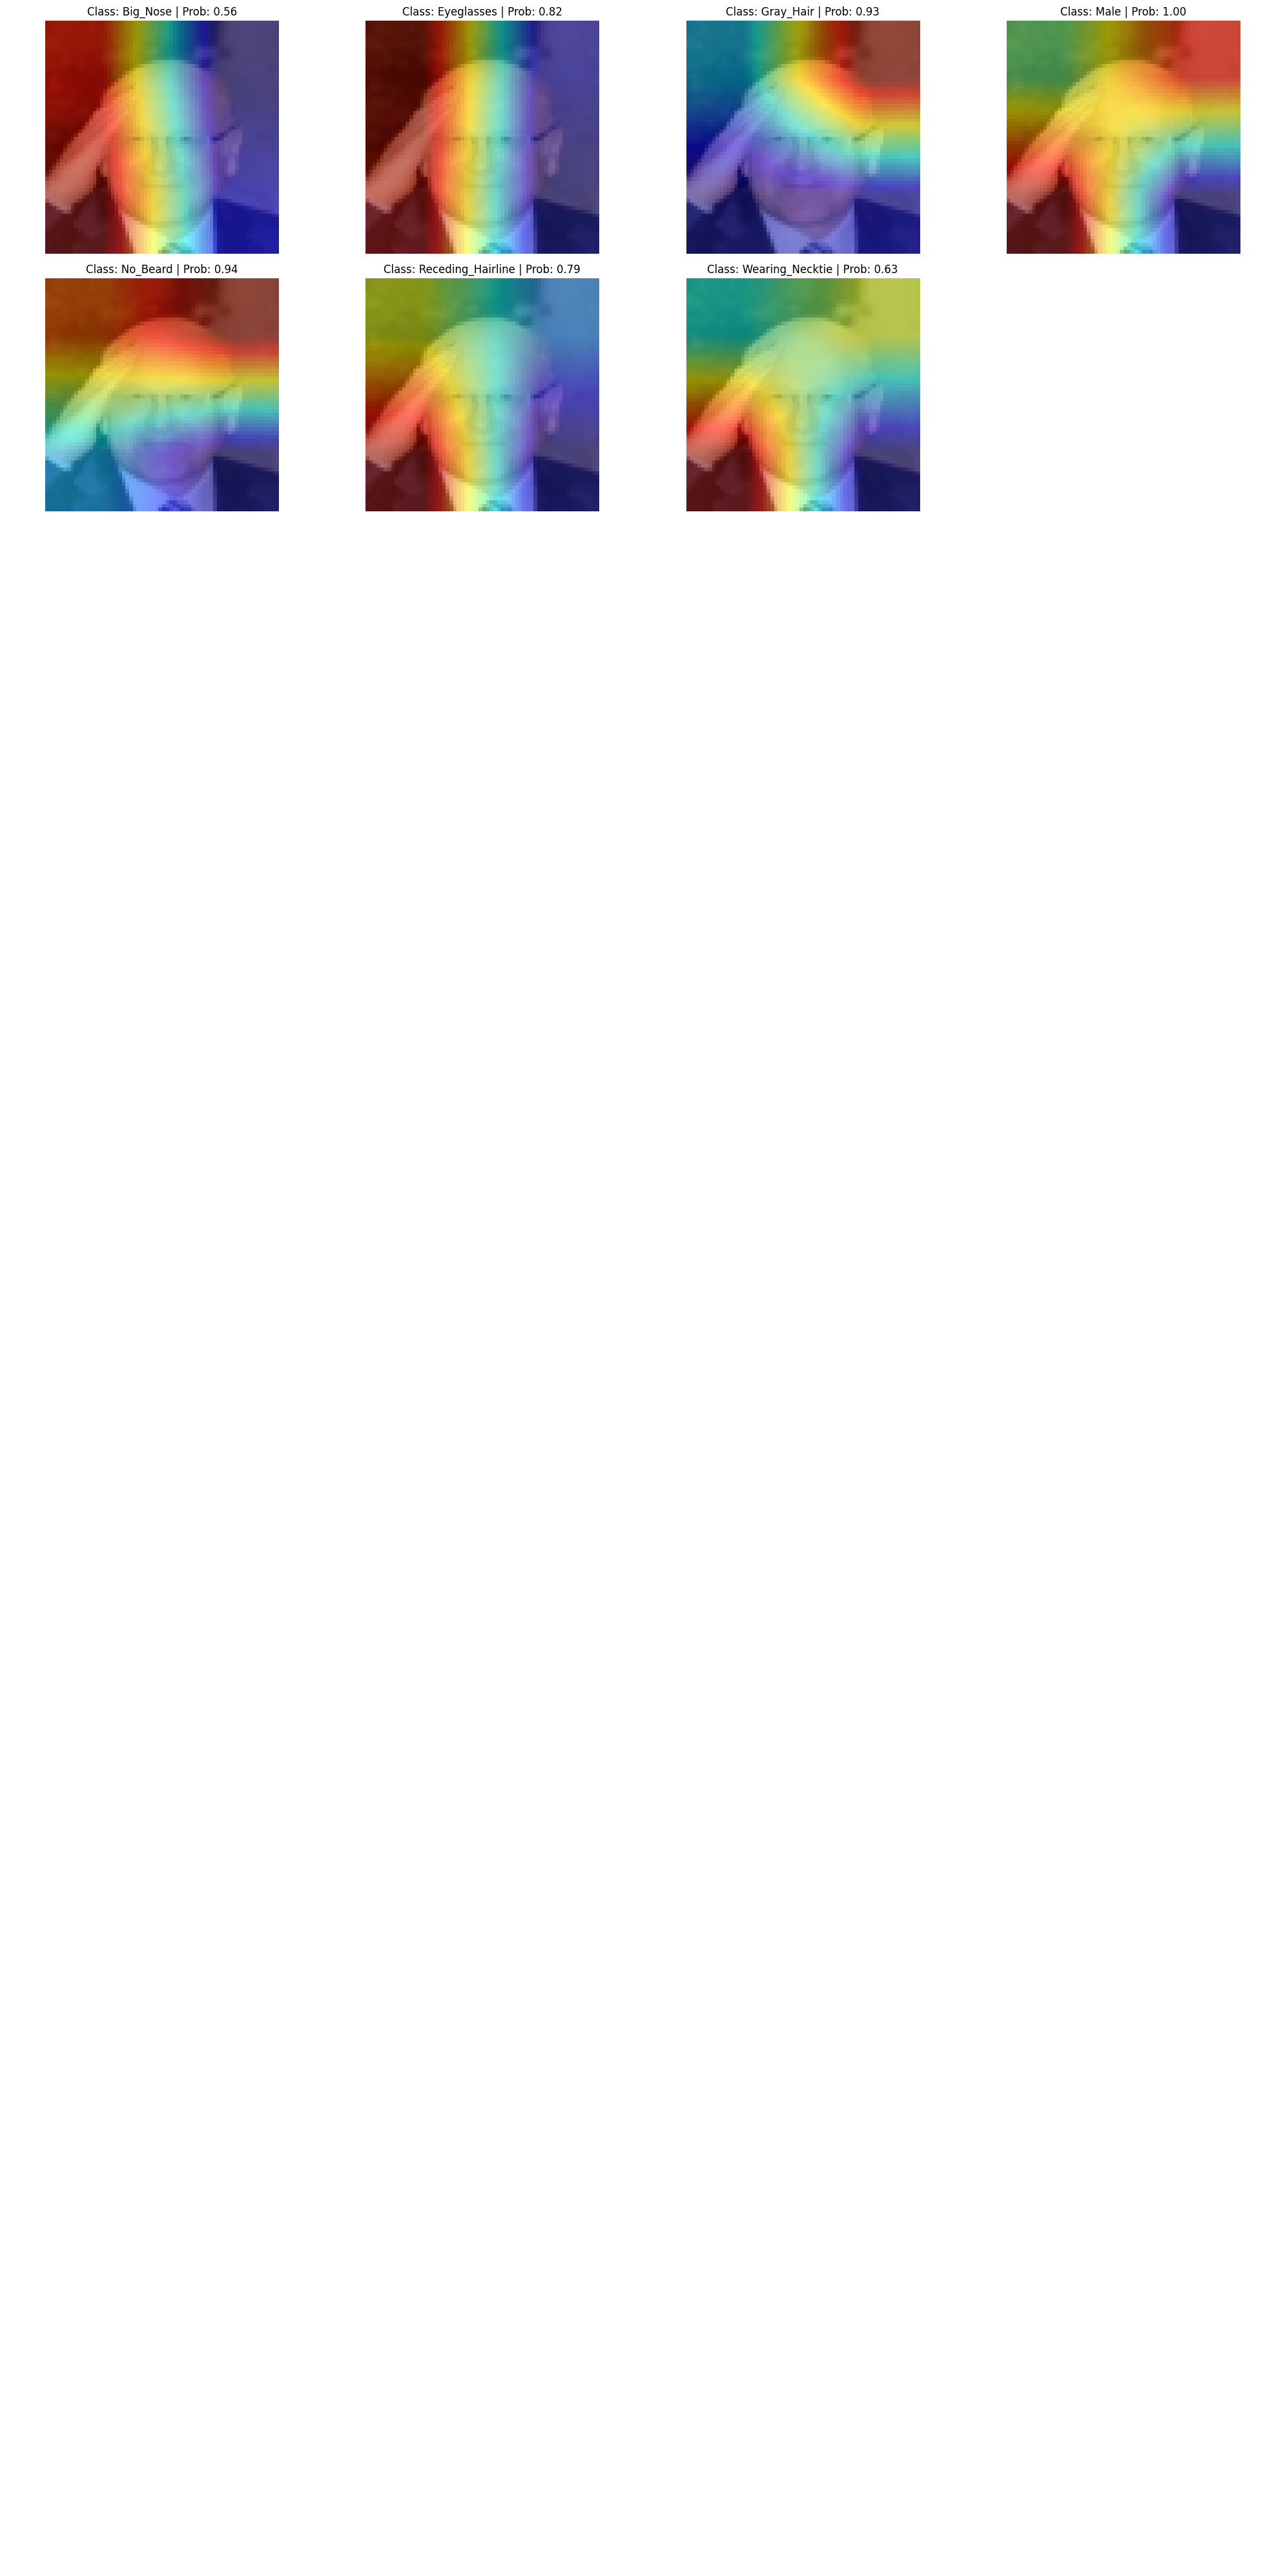

In [ ]:


image = image.to(device)

# Grad-CAM setup (assuming you've defined the GradCAM class)
grad_campp = GradCAMPlusPlus(model, target_layer='layer4')  # Target layer for ResNet18

# Forward pass through the model to get predictions
model.to(device)
model.eval()
outputs = model(image)
outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
outputs = outputs.squeeze()  # Remove extra dimensions


print ("outputs shape : ", outputs.shape)

# Select the classes with confidence >= 50%
threshold = 0.5
selected_classes = (outputs >= threshold).nonzero(as_tuple=True)[0]  # Get indices of confident predictions
selected_probs = outputs[selected_classes].detach().cpu().numpy()  # Get the probabilities of these predictions

# Visualize CAM for each selected class in a 10x4 grid
fig, axs = plt.subplots(10, 4, figsize=(20, 40))

# Prepare the image for CAM visualization
image_np = image[0].cpu().numpy().transpose(1, 2, 0)  # Convert from tensor to NumPy array
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize the image

for i, class_index in enumerate(selected_classes):
    if i >= 40:  # Limit to 40 images (10x4 grid)
        break

    # Generate CAM for the selected class
    cam = grad_campp(image, class_index=class_index.item())

    # Visualize the CAM
    cam_image = visualize_cam(cam, image_np)

    # Plot the image with the corresponding label and probability
    ax = axs[i // 4, i % 4]
    ax.imshow(cam_image)
    ax.set_title(f"Class: {label_names[class_index.item()]} | Prob: {selected_probs[i]:.2f}")
    ax.axis('off')

# Hide unused subplots if any
for j in range(i + 1, 40):
    axs[j // 4, j % 4].axis('off')

plt.tight_layout()
plt.show()


### Regression

#### Spoiler -- It may not work !!! 😱

Grad-CAM and its variants (like Grad-CAM++ and HighResCAM) are primarily designed for **classification tasks**, where the goal is to highlight regions in an image that contribute to the model's prediction of specific classes. They are not well-suited for **regression tasks** due to fundamental differences in the nature of classification and regression models. Here's why CAM techniques don't perform well in regression tasks:

#### 1. **Absence of Discrete Class Targets**
- **In classification**: The model has discrete output classes (e.g., "dog," "cat," etc.). Grad-CAM works by calculating the gradient of the score for a specific class with respect to the feature maps of a convolutional layer. This allows the method to attribute importance to different parts of the image for a specific class prediction.
- **In regression**: The output is continuous (e.g., predicting a number or a range of values). There is no discrete class score to compute gradients with respect to, making it difficult to determine which regions of the image influence a continuous prediction.

#### 2. **Gradient Behavior**
- In **classification**, the gradient of the class score with respect to the feature maps helps to identify the most important regions for a particular class. The gradients are sharp and directed towards optimizing a specific class probability, which makes it easier for Grad-CAM to generate meaningful heatmaps.
- In **regression**, the gradients are much less structured because the model is not optimizing for discrete class scores. The gradients tend to be smaller and more distributed across the input, often leading to less informative and more diffuse heatmaps. This causes CAM methods to struggle in highlighting relevant regions.

#### 3. **Lack of Distinctive Features**
- In classification, different classes often correspond to distinctive features or patterns (e.g., "dog" might correspond to certain shapes, textures, or colors in the image). This makes it easier for CAM techniques to identify specific areas in the image relevant to each class.
- In regression, the target is typically a scalar value rather than a discrete class. The lack of distinctive features tied to a specific target value makes it hard for CAM methods to highlight specific regions in the image.

#### 4. **Multi-Dimensional Output in Regression**
- Many regression problems have multi-dimensional output (e.g., predicting multiple continuous variables). CAM techniques are typically designed to handle single-output (class score) cases. For multi-dimensional regression tasks, there may be no clear mapping between a single output and specific regions in the image, leading to less precise heatmaps.

#### 5. **Non-Discriminative Targets**
- In classification tasks, Grad-CAM works by discriminating between different classes. For example, it can highlight which parts of the image made the model predict "cat" instead of "dog."
- In regression tasks, the continuous target is non-discriminative (i.e., you are not comparing between multiple classes), which makes it difficult to create a meaningful visualization of which parts of the image contributed to the prediction.

#### 6. **Model Architecture Differences**
- Many regression models do not use the same architectures or layers as classification models. For example, fully connected layers or specific pooling strategies used in classification may not be present in regression models. Since Grad-CAM relies on specific layers (usually convolutional layers) to generate heatmaps, the absence of these architectural elements in regression models can make it difficult for Grad-CAM to function properly.

#### 7. **Global vs. Local Features**
- In classification, certain regions of the image can have a strong influence on class prediction. For example, the ears of a dog might heavily influence the decision of whether the image is classified as a "dog."
- In regression, the prediction might depend on global features of the image rather than localized regions. This means that no specific part of the image is responsible for the output, making CAM techniques less effective at identifying influential areas.

---

#### Potential Adjustments for Regression
While traditional Grad-CAM doesn't perform well in regression tasks, adaptations or alternative methods could be used to address this:

1. **Modified Gradient Approaches**: Modifying Grad-CAM to take into account the continuous nature of regression outputs could help, such as using different weighting strategies or focusing on higher-order gradients.

2. **Attention Mechanisms**: Using attention-based methods to visualize which parts of an image are most influential in regression models might be more effective than CAM techniques.

3. **Saliency Maps**: Instead of CAM, techniques like saliency maps or integrated gradients might perform better for regression, as they directly highlight important input features without relying on class scores.


In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G?usp=sharing

Retrieving folder contents
Processing file 1mb5Z24TsnKI3ygNIlX6ZFiwUj0_PmpAW part1.tar.gz
Processing file 19vdaXVRtkP-nyxz1MYwXiFsh_m_OL72b part2.tar.gz
Processing file 1oj9ZWsLV2-k2idoW_nRSrLQLUP3hus3b part3.tar.gz
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1mb5Z24TsnKI3ygNIlX6ZFiwUj0_PmpAW
From (redirected): https://drive.google.com/uc?id=1mb5Z24TsnKI3ygNIlX6ZFiwUj0_PmpAW&confirm=t&uuid=5573bd8c-534d-4fff-ba37-c25d0ba19016
To: /content/UTKface_inthewild/part1.tar.gz
100% 874M/874M [00:10<00:00, 82.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19vdaXVRtkP-nyxz1MYwXiFsh_m_OL72b
From (redirected): https://drive.google.com/uc?id=19vdaXVRtkP-nyxz1MYwXiFsh_m_OL72b&confirm=t&uuid=349374fb-e2c4-4536-bc02-d84ed33228b4
To: /content/UTKface_inthewild/part2.tar.gz
100% 459M/459M [00:07<00:00, 58.1MB/s]
Downloading...
From (original): https://drive.g

In [ ]:
!ls -lrth UTKface_inthewild
# Extract part1.tar.gz
!tar -xzvf UTKface_inthewild/part1.tar.gz -C UTKface_inthewild/

# Extract part2.tar.gz
!tar -xzvf UTKface_inthewild/part2.tar.gz -C UTKface_inthewild/

# Extract part3.tar.gz
!tar -xzvf UTKface_inthewild/part3.tar.gz -C UTKface_inthewild/

In [ ]:
!ls -lrth UTKface_inthewild

# Move all .jpg files from subdirectories to UTKface_inthewild/
!find UTKface_inthewild/ -name '*.jpg' -exec mv {} UTKface_inthewild/ \;

# Remove the .tar.gz files
!rm UTKface_inthewild/part1.tar.gz UTKface_inthewild/part2.tar.gz UTKface_inthewild/part3.tar.gz

# Remove the extracted directories (assuming they were extracted into directories named part1, part2, and part3)
!rm -r UTKface_inthewild/part1 UTKface_inthewild/part2 UTKface_inthewild/part3

total 1.3G
drwxr-xr-x 2 22294  143 528K Jan 12  2017 part1
drwxr-xr-x 2 22294  143 532K Jan 18  2017 part2
drwxr-xr-x 2 22294  143 160K Jan 21  2017 part3
-rw-r--r-- 1 root  root 834M Sep 30  2021 part1.tar.gz
-rw-r--r-- 1 root  root  55M Sep 30  2021 part3.tar.gz
-rw-r--r-- 1 root  root 438M Sep 30  2021 part2.tar.gz


In [ ]:
image_path = 'UTKface_inthewild/26_0_3_20170120134330671.jpg'
img = Image.open(image_path)

In [ ]:
to_tensor = transforms.ToTensor()
img_tensor = to_tensor(img)

print("Pixel values before normalization (sample 5x5 from the first channel):")
print(img_tensor[0, :5, :5].numpy())  # Print the first 5x5 pixels from the first channel (R)

print(f"Min pixel value: {torch.min(img_tensor)}")
print(f"Max pixel value: {torch.max(img_tensor)}")

Pixel values before normalization (sample 5x5 from the first channel):
[[0.76862746 0.77254903 0.76862746 0.7764706  0.78431374]
 [0.77254903 0.77254903 0.77254903 0.7764706  0.78431374]
 [0.77254903 0.7764706  0.77254903 0.78039217 0.7882353 ]
 [0.7764706  0.78039217 0.7764706  0.78431374 0.7882353 ]
 [0.78039217 0.78431374 0.78039217 0.7882353  0.7921569 ]]
Min pixel value: 0.0
Max pixel value: 1.0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader, random_split

# Custom Dataset Class for UTKFace
class UTKFaceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path)

        # Debugging: Print the mode of the image
        #print(f"Loading image {img_path}, mode: {image.mode}")

        # Convert image to RGB if it is grayscale or has an alpha channel
        if image.mode != 'RGB':
            image = image.convert('RGB')
            print(f"Converted image to RGB mode")


        # Age is the first part of the filename
        age = int(self.image_filenames[idx].split('_')[0])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(age, dtype=torch.float32)


In [ ]:
# Transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1] and image with pixel values contained in [0,1]
])

# Create dataset
image_dir = 'UTKface_inthewild/'  # Directory where your .jpg files are located
dataset = UTKFaceDataset(image_dir=image_dir, transform=transform)

print (f"Total size of the dataset is {len(dataset)}")

train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Define DataLoaders for each dataset with a given batch size
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example of using the DataLoader in a training loop
for images, ages in train_loader:
    print(f"images.shape: {images.shape}")  # Should be [batch_size, 3, 128, 128] for RGB images
    print(ages)  # Tensor of ages corresponding to the batch of images
    # Training code here...
    break  # Just to show the first batch; remove in actual training

Total size of the dataset is 24106
images.shape: torch.Size([64, 3, 128, 128])
tensor([32., 43., 24., 27.,  1., 30., 62.,  8., 26., 26., 18., 31., 52., 36.,
        56., 26., 80., 22.,  3., 89., 29., 26., 38., 30., 28., 26., 26., 60.,
         1.,  2., 45., 45., 50., 52.,  1., 59., 27., 26., 14., 31., 15.,  5.,
         3.,  1., 25., 18.,  7., 58., 54., 35., 50.,  6., 52., 26., 24., 26.,
        45., 22.,  2.,  1.,  2., 50.,  1., 24.])


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim

# Load the pretrained ResNet18 model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze the feature extraction layers except the layers needed for Grad-CAM
for name, param in model.named_parameters():
    if "layer4" not in name and "layer3" not in name:  # Only unfreeze layer4 and layers after it
        param.requires_grad = False

# Modify the final fully connected layer for regression
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Output 1 continuous value for regression

# Define loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Use Adam optimizer, only update parameters in the modified final layers and unfrozen layers
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


In [ ]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)  # Squeeze to match the shape for regression
        loss = criterion(outputs, labels.float())  # Ensure labels are float type for regression

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    validation_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels.float())
            validation_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {validation_loss / len(val_loader):.4f}')

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


Converted image to RGB mode
Converted image to RGB mode


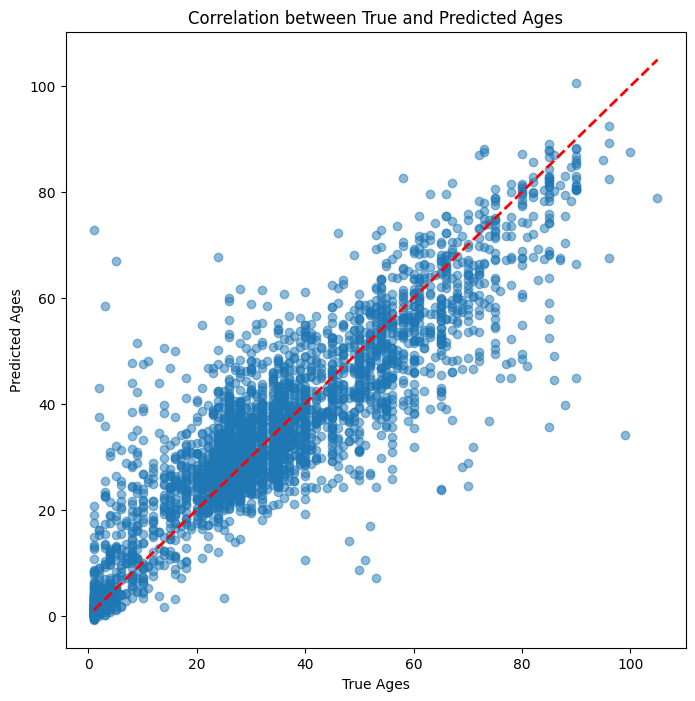

In [ ]:

import matplotlib.pyplot as plt

# Assuming `test_loader` is your DataLoader for the test dataset

# Collect true and predicted ages
true_ages = []
predicted_ages = []

# Put the model in evaluation mode
model.eval()

# Turn off gradient computation for testing
with torch.no_grad():
    for images, ages in test_loader:
        images = images.to(device)
        ages = ages.to(device)

        # Get predictions from the model
        outputs = model(images).squeeze()  # Assuming the model returns a single value for regression

        # Collect the true and predicted ages
        true_ages.extend(ages.cpu().numpy())
        # Convert the outputs tensor to a 1D numpy array
        predicted_ages.extend(outputs.cpu().numpy().flatten())

# Plot the correlation between true and predicted ages
plt.figure(figsize=(8, 8))
plt.scatter(true_ages, predicted_ages, alpha=0.5)
plt.plot([min(true_ages), max(true_ages)], [min(true_ages), max(true_ages)], 'r--', lw=2)  # y=x line
plt.xlabel('True Ages')
plt.ylabel('Predicted Ages')
plt.title('Correlation between True and Predicted Ages')
plt.show()

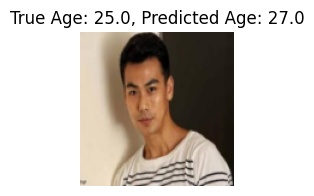

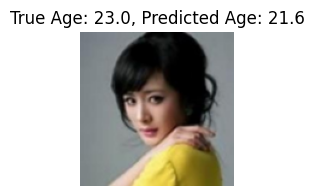

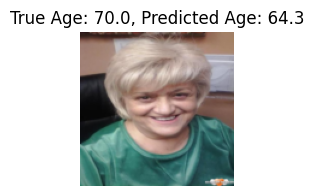

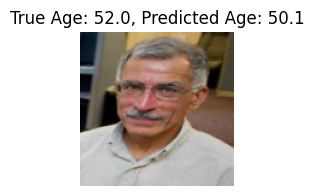

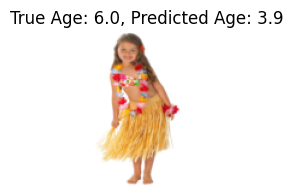

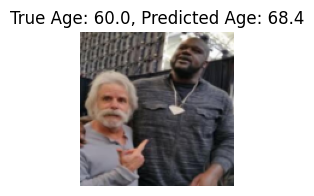

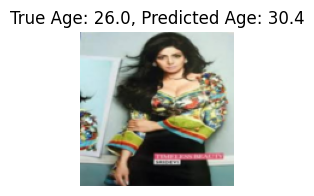

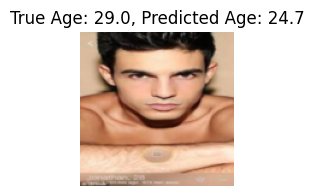

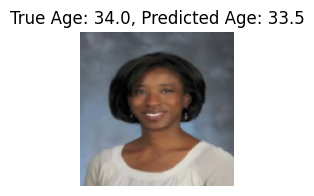

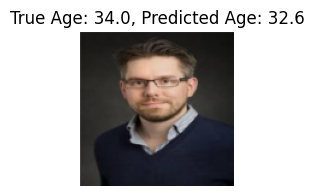

In [ ]:
import matplotlib.pyplot as plt

# Display 10 images with their true and predicted ages
def show_predictions(model, test_loader, device):
    model.eval()
    images_shown = 0

    # Turn off gradients for validation
    with torch.no_grad():
        for images, ages in test_loader:
            images = images.to(device)
            ages = ages.to(device)

            # Get model predictions
            outputs = model(images).squeeze()  # Predicted ages

            # Display first 10 images with true and predicted ages
            for i in range(min(10, images.size(0))):  # Show up to 10 images
                plt.figure(figsize=(2, 2))
                img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format for plotting
                img = (img * 0.5) + 0.5  # Denormalize the image to [0, 1] range

                # Plot the image
                plt.imshow(img)
                plt.title(f'True Age: {ages[i].item():.1f}, Predicted Age: {outputs[i].item():.1f}')
                plt.axis('off')

                images_shown += 1
                if images_shown == 10:
                    return  # Stop after showing 10 images

# Call the function to show the predictions
show_predictions(model, test_loader, device)

In [ ]:
def filter_by_age(dataset, target_age):
    indices = [i for i, (img, age) in enumerate(dataset) if age == target_age]
    return torch.utils.data.Subset(dataset, indices)

test_loader_age_25 = DataLoader(filter_by_age(test_dataset, 25), batch_size=1, shuffle=False)
test_loader_age_50 = DataLoader(filter_by_age(test_dataset, 50), batch_size=1, shuffle=False)
test_loader_age_16 = DataLoader(filter_by_age(test_dataset, 16), batch_size=1, shuffle=False)


Converted image to RGB mode
Converted image to RGB mode
Converted image to RGB mode
Converted image to RGB mode
Converted image to RGB mode
Converted image to RGB mode


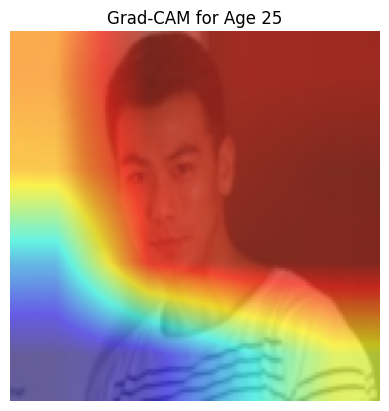

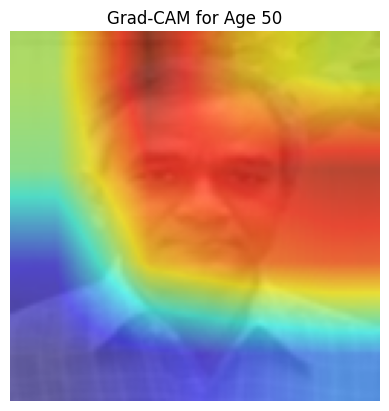

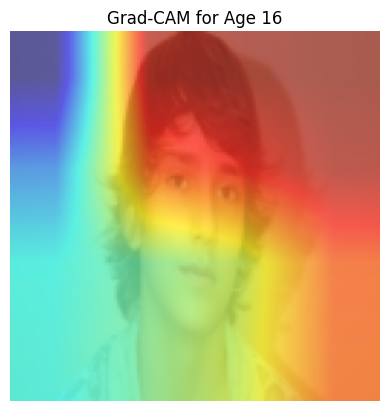

In [ ]:

import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
import requests
from io import BytesIO
from PIL import Image  # Make sure to import Image

# Define Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.forward_output = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.forward_output = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_layer = dict(self.model.named_modules())[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def forward(self, x):
        return self.model(x)

    def __call__(self, input_image, class_index=None):
        output = self.forward(input_image)

        if class_index is None:
            class_index = output.argmax()

        self.model.zero_grad()
        class_score = output[:, 0]
        class_score.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        forward_output = self.forward_output[0].cpu().data.numpy()

        # Global average pooling of gradients
        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(forward_output.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * forward_output[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam


# Visualization function for heatmap
def visualize_cam(cam, image, alpha=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(image)
    cam_image = cam_image / np.max(cam_image)
    return np.uint8(255 * cam_image)

# Define Grad-CAM instance
gradcam = GradCAM(model, target_layer='layer4')

# Function to apply Grad-CAM and visualize the result for a given test loader
def apply_gradcam(test_loader, age_label, gradcam, model):
    model.eval()  # Ensure model is in evaluation mode
    for images, labels in test_loader:
        images = images.to(device)

        # Perform Grad-CAM
        cam = gradcam(images)

        # Convert the input image to displayable format
        original_image = images.cpu().squeeze().permute(1, 2, 0).numpy()
        original_image = original_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        original_image = np.clip(original_image, 0, 1)

        # Visualize the Grad-CAM
        cam_image = visualize_cam(cam, original_image)
        plt.imshow(cam_image)
        plt.title(f'Grad-CAM for Age {age_label}')
        plt.axis('off')
        plt.show()
        break  # Stop after showing the first batch

# Apply Grad-CAM for ages 25, 50, and 16
apply_gradcam(test_loader_age_25, 25, gradcam, model)
apply_gradcam(test_loader_age_50, 50, gradcam, model)
apply_gradcam(test_loader_age_16, 16, gradcam, model)

In [ ]:
import torch
import numpy as np
import cv2
import torch.nn.functional as F

class HighResCAM:
    def __init__(self, model, target_layers):
        """
        Initialize the HighResCAM class.

        Args:
            model: The pre-trained model (e.g., ResNet18).
            target_layers: List of layers to hook for high-resolution CAM.
        """
        self.model = model
        self.target_layers = target_layers  # List of layers for high-resolution
        self.gradients = {}
        self.activations = {}
        self.model.eval()  # Ensure the model is in evaluation mode
        self.hook_layers()

    def hook_layers(self):
        """Attach hooks to target layers to capture gradients and activations."""
        def forward_hook(name):
            def hook(module, input, output):
                self.activations[name] = output  # Store the forward output (activation map)
            return hook

        def backward_hook(name):
            def hook(module, grad_in, grad_out):
                self.gradients[name] = grad_out[0]  # Store the gradients
            return hook

        # Hook the forward and backward hooks to the target layers
        for layer_name in self.target_layers:
            layer = dict(self.model.named_modules())[layer_name]
            layer.register_forward_hook(forward_hook(layer_name))
            layer.register_full_backward_hook(backward_hook(layer_name))

    def forward(self, x):
        """Forward pass through the model."""
        return self.model(x)

    def __call__(self, input_image, class_index=None):
        """
        Generate the high-resolution class activation map for a given input image.

        Args:
            input_image: Input image tensor.
            class_index: Index of the class for which to generate CAM.
                         If None, the highest score class is used.
        Returns:
            High-resolution class activation map (CAM) as a NumPy array.
        """
        # Forward pass
        output = self.forward(input_image)

        if class_index is None:
            class_index = torch.argmax(output)  # Use the top predicted class if none is specified

        # Backward pass
        self.model.zero_grad()  # Zero gradients
        class_score = output[:, class_index]
        class_score.backward()  # Compute gradients for the selected class

        # Generate high-resolution CAM by combining activations from multiple layers
        highres_cam = None
        input_size = input_image.shape[2:]  # Height and width of the input image

        for layer_name in self.target_layers:
            # Get gradients and activations for the current layer
            gradients = self.gradients[layer_name].cpu().data.numpy()
            activations = self.activations[layer_name].cpu().data.numpy()

            # Compute the weights using global average pooling on the gradients
            weights = np.mean(gradients, axis=(2, 3))  # Shape: (batch_size, num_channels)

            # Compute the weighted sum of the activation maps
            cam = np.zeros(activations.shape[2:], dtype=np.float32)  # Initialize CAM
            for i, w in enumerate(weights[0]):  # Iterate over channels
                cam += w * activations[0, i, :, :]

            # Apply ReLU to keep only positive values
            cam = np.maximum(cam, 0)

            # Resize the CAM to match the input size
            cam = cv2.resize(cam, input_size)

            # Normalize the CAM
            cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

            # Combine CAMs from different layers
            if highres_cam is None:
                highres_cam = cam
            else:
                highres_cam += cam  # Aggregate CAMs from multiple layers

        # Normalize the combined high-res CAM
        highres_cam = (highres_cam - np.min(highres_cam)) / (np.max(highres_cam) - np.min(highres_cam) + 1e-8)

        return highres_cam

# Visualization function for high-res CAM
def visualize_highres_cam(cam, image, alpha=0.5):
    """
    Visualize the high-resolution CAM overlayed on the original image.

    Args:
        cam: The high-resolution CAM.
        image: The original input image as a NumPy array.
        alpha: The blending factor for overlay.

    Returns:
        Blended image with CAM overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(image)
    cam_image = cam_image / np.max(cam_image)
    return np.uint8(255 * cam_image)


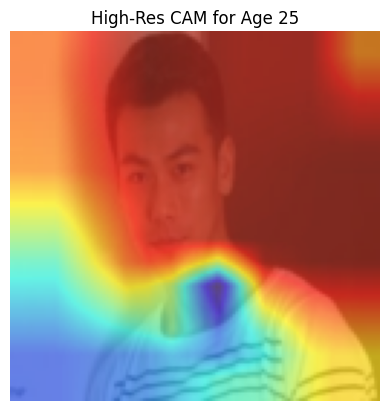

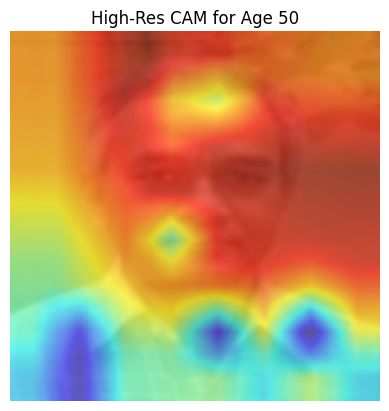

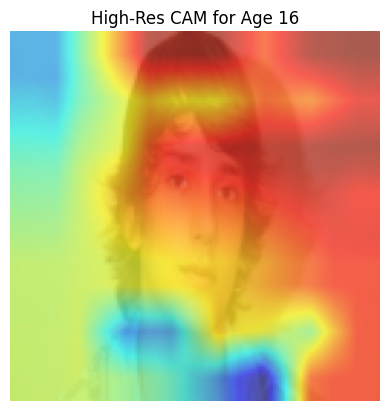

In [ ]:
# Apply HighResCAM for ages 25, 50, and 16

# Define target layers for high-resolution CAM (e.g., layer3 and layer4 for ResNet18)
target_layers = ['layer3', 'layer4']

# Initialize HighResCAM
highres_cam = HighResCAM(model, target_layers)

# Function to apply HighResCAM on the test data for a specific age
def apply_highres_cam(test_loader, age_label, highres_cam, model):
    model.eval()  # Ensure model is in evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for images, ages in test_loader:
        images = images.to(device)

        # Perform HighResCAM
        cam = highres_cam(images)

        # Convert the input image to displayable format
        original_image = images.cpu().squeeze().permute(1, 2, 0).numpy()
        original_image = original_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        original_image = np.clip(original_image, 0, 1)

        # Visualize the HighResCAM
        cam_image = visualize_highres_cam(cam, original_image)
        plt.imshow(cam_image)
        plt.title(f'High-Res CAM for Age {age_label}')
        plt.axis('off')
        plt.show()
        break  # Stop after showing the first batch

# Apply HighResCAM for ages 25, 50, and 16
apply_highres_cam(test_loader_age_25, 25, highres_cam, model)
apply_highres_cam(test_loader_age_50, 50, highres_cam, model)
apply_highres_cam(test_loader_age_16, 16, highres_cam, model)


#### Gradcam++


In [ ]:
import torch
import numpy as np
import cv2
import torch.nn.functional as F

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.model.eval()  # Ensure the model is in evaluation mode
        self.hook_layers()

    def hook_layers(self):
        """Attach hooks to the target layer to capture gradients and activations."""
        def forward_hook(module, input, output):
            self.activations = output  # Capture the forward activations

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]  # Capture the gradients

        target_layer = dict(self.model.named_modules())[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def forward(self, x):
        return self.model(x)

    def __call__(self, input_image, class_index=None):
        # Forward pass
        output = self.forward(input_image)

        if class_index is None:
            # Use the top predicted class if none is specified
            class_index = torch.argmax(output)

        self.model.zero_grad()  # Zero all gradients
        class_score = output[:, class_index]  # Select the class score
        class_score.backward(retain_graph=True)  # Compute gradients

        # Get gradients and activations for the target layer
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute alpha (importance weight for each pixel location)
        alpha_num = gradients ** 2
        alpha_denom = 2 * gradients ** 2 + np.sum(activations * gradients ** 3, axis=(1, 2), keepdims=True)
        alpha_denom = np.where(alpha_denom != 0, alpha_denom, 1e-8)  # Avoid division by zero
        alpha = alpha_num / alpha_denom

        # Compute weights
        weights = np.sum(alpha * np.maximum(gradients, 0), axis=(1, 2))

        # Compute the Grad-CAM++ map
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Resize CAM to match input size
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))

        # Normalize CAM to [0, 1]
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)

        return cam

# Visualization function for Grad-CAM++
def visualize_gradcamplusplus(cam, image, alpha=0.5):
    """
    Visualize the Grad-CAM++ heatmap overlayed on the original image.

    Args:
        cam: The Grad-CAM++ map.
        image: The original input image as a NumPy array.
        alpha: The blending factor for overlay.

    Returns:
        Blended image with CAM overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(image)
    cam_image = cam_image / np.max(cam_image)
    return np.uint8(255 * cam_image)


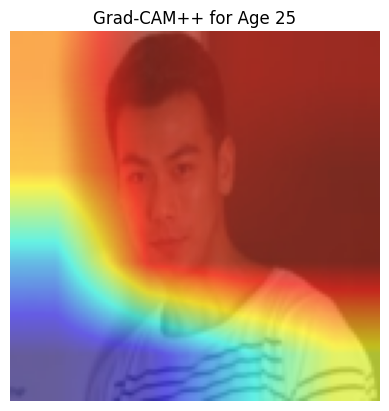

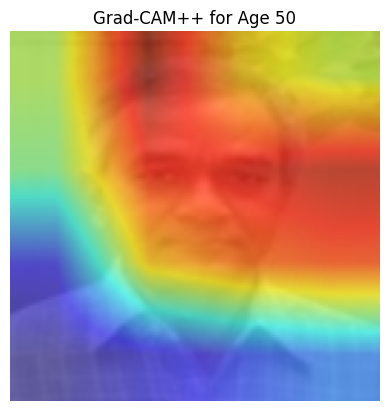

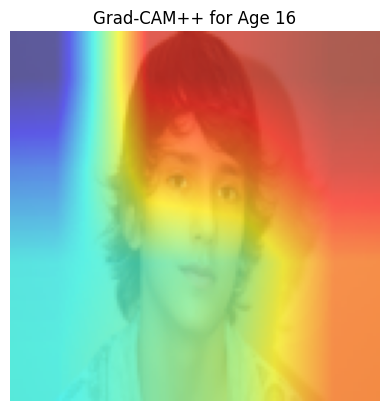

In [ ]:
# Instantiate Grad-CAM++ for ResNet18's layer4
gradcam_pp = GradCAMPlusPlus(model, target_layer='layer4')

# Function to apply Grad-CAM++ on the test data for a specific age
def apply_gradcam_pp(test_loader, age_label, gradcam_pp, model):
    model.eval()  # Ensure model is in evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for images, ages in test_loader:
        images = images.to(device)

        # Perform Grad-CAM++
        cam = gradcam_pp(images)

        # Convert the input image to displayable format
        original_image = images.cpu().squeeze().permute(1, 2, 0).numpy()
        original_image = original_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        original_image = np.clip(original_image, 0, 1)

        # Visualize the Grad-CAM++
        cam_image = visualize_gradcamplusplus(cam, original_image)
        plt.imshow(cam_image)
        plt.title(f'Grad-CAM++ for Age {age_label}')
        plt.axis('off')
        plt.show()
        break  # Stop after showing the first batch

# Apply Grad-CAM++ for ages 25, 50, and 16
apply_gradcam_pp(test_loader_age_25, 25, gradcam_pp, model)
apply_gradcam_pp(test_loader_age_50, 50, gradcam_pp, model)
apply_gradcam_pp(test_loader_age_16, 16, gradcam_pp, model)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save the model in Google Drive
model_save_path = '/content/drive/MyDrive/models/resnet18_model.pth'
# Assuming `model` is your trained model
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/models/resnet18_model.pth
